In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.7 MB/s eta 0:00:00


In [ ]:
!pip install tqdm

In [ ]:
!pip install scikit-learn

In [ ]:
pip install seaborn

In [2]:
# ==========================
# YOLO + ResNet50 Pipeline (Windows-friendly, ready-to-run)
# ==========================
import os
import copy
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm   # ✅ เพิ่มมาแล้ว

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import torch.nn.functional as F


from PIL import Image
from ultralytics import YOLO

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split  # ✅ เพิ่มมาแล้ว

In [3]:
# ==========================
# 0️⃣ Set Seed
# ==========================
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
data_dir = r"/content/drive/MyDrive/Project/Center New"  # ปรับตามเครื่อง
# yolo_weights = "best.pt"           # ปรับตามไฟล์
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
# =========================
# 1️⃣ Dataset Check (Recursive Dataset Check)
# =========================
def check_dataset_recursive(data_dir):
    img_ext = (".jpg", ".jpeg", ".png", ".bmp")

    total_images = 0
    folders_with_images = []

    if not os.path.exists(data_dir):
        raise ValueError(f"ไม่พบ path: {data_dir}")

    # เดินทุกโฟลเดอร์ย่อย
    for root, dirs, files in os.walk(data_dir):

        image_files = [
            f for f in files
            if f.lower().endswith(img_ext)
        ]

        if len(image_files) > 0:
            print(f"✅ {root} : {len(image_files)} รูป")
            folders_with_images.append((root, len(image_files)))
            total_images += len(image_files)

    # ===== Summary =====
    print("\n========== Summary ==========")
    print(f"โฟลเดอร์ที่มีรูป: {len(folders_with_images)}")
    print(f"จำนวนรูปทั้งหมด: {total_images}")

    return total_images, folders_with_images


# ===== Run =====
total_images, folder_info = check_dataset_recursive(data_dir)

if total_images == 0:
    raise RuntimeError("❌ ไม่พบไฟล์รูปภาพใน dataset เลย!")


✅ /content/drive/MyDrive/Project/Center New/T1 : 272 รูป
✅ /content/drive/MyDrive/Project/Center New/T3 : 41 รูป
✅ /content/drive/MyDrive/Project/Center New/T2 : 76 รูป
✅ /content/drive/MyDrive/Project/Center New/T4 : 27 รูป

========== Summary ==========
โฟลเดอร์ที่มีรูป: 4
จำนวนรูปทั้งหมด: 416


In [6]:
# ==========================
#  2️⃣Transform / Augmentation
# ==========================
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [7]:
# ==========================
# 3️⃣ Load Dataset (SPLIT)
# ==========================
# โหลด dataset ก่อน (ยังไม่ใส่ transform)
dataset = datasets.ImageFolder(
    root=data_dir,
    transform=None
)

class_names = dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)
print("Total images:", len(dataset))

# ==========================
# Stratified Split 80/10/10
# ==========================

targets = np.array(dataset.targets)

# 80% Train
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

# 10% Validation / 10% Test
valid_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=targets[temp_idx],
    random_state=42
)

# ==========================
# สร้าง dataset แยก และกำหนด transform ให้ถูกต้อง
# ==========================

train_dataset = Subset(
    datasets.ImageFolder(root=data_dir, transform=transform_train),
    train_idx
)

valid_dataset = Subset(
    datasets.ImageFolder(root=data_dir, transform=transform_test),
    valid_idx
)

test_dataset = Subset(
    datasets.ImageFolder(root=data_dir, transform=transform_test),
    test_idx
)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

# ==========================
# DataLoader
# ==========================

batch_size = 16
num_workers = 4
pin_memory = True if torch.cuda.is_available() else False

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

Classes: ['T1', 'T2', 'T3', 'T4']
Number of classes: 4
Total images: 416
Train size: 332
Validation size: 42
Test size: 42


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
# ==========================
# 4️⃣ Load ResNet-50 (Pretrained)
# ==========================

# โหลด ResNet-50 ที่ผ่านการฝึกมาแล้ว
resnet50 = models.resnet50(pretrained=True)

# แก้ Fully Connected Layer สุดท้าย
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)

resnet50 = resnet50.to(device)

# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    resnet50.parameters(),
    lr=0.0001
)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# ==========================
# 5️⃣ Training Loop
# ==========================

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_acc = 0.0

num_epochs = 50

for epoch in range(num_epochs):

    # ===== TRAIN =====
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # ===== VALIDATION =====
    resnet50.eval()
    valid_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = resnet50(images)
            loss = criterion(outputs, labels)

            valid_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = valid_running_loss / len(test_loader)
    valid_acc = 100 * correct / total

    # เก็บค่า
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"\nTrain Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.2f}%"
          f"\nValid Loss: {valid_loss:.4f} "
          f"Valid Acc: {valid_acc:.2f}%")

Epoch [1/50] 
Train Loss: 0.9735 Train Acc: 62.95%
Valid Loss: 1.0256 Valid Acc: 66.67%
Epoch [2/50] 
Train Loss: 0.6431 Train Acc: 73.49%
Valid Loss: 0.5631 Valid Acc: 78.57%
Epoch [3/50] 
Train Loss: 0.4758 Train Acc: 81.33%
Valid Loss: 0.5426 Valid Acc: 80.95%
Epoch [4/50] 
Train Loss: 0.3464 Train Acc: 87.95%
Valid Loss: 0.6935 Valid Acc: 83.33%
Epoch [5/50] 
Train Loss: 0.2819 Train Acc: 89.46%
Valid Loss: 0.3655 Valid Acc: 95.24%
Epoch [6/50] 
Train Loss: 0.2050 Train Acc: 93.07%
Valid Loss: 0.4268 Valid Acc: 92.86%
Epoch [7/50] 
Train Loss: 0.1218 Train Acc: 96.39%
Valid Loss: 0.4636 Valid Acc: 85.71%
Epoch [8/50] 
Train Loss: 0.1848 Train Acc: 93.07%
Valid Loss: 0.3265 Valid Acc: 90.48%
Epoch [9/50] 
Train Loss: 0.1348 Train Acc: 94.88%
Valid Loss: 0.5511 Valid Acc: 88.10%
Epoch [10/50] 
Train Loss: 0.1160 Train Acc: 96.08%
Valid Loss: 0.7609 Valid Acc: 88.10%
Epoch [11/50] 
Train Loss: 0.1523 Train Acc: 95.78%
Valid Loss: 0.6051 Valid Acc: 80.95%
Epoch [12/50] 
Train Loss: 0.2

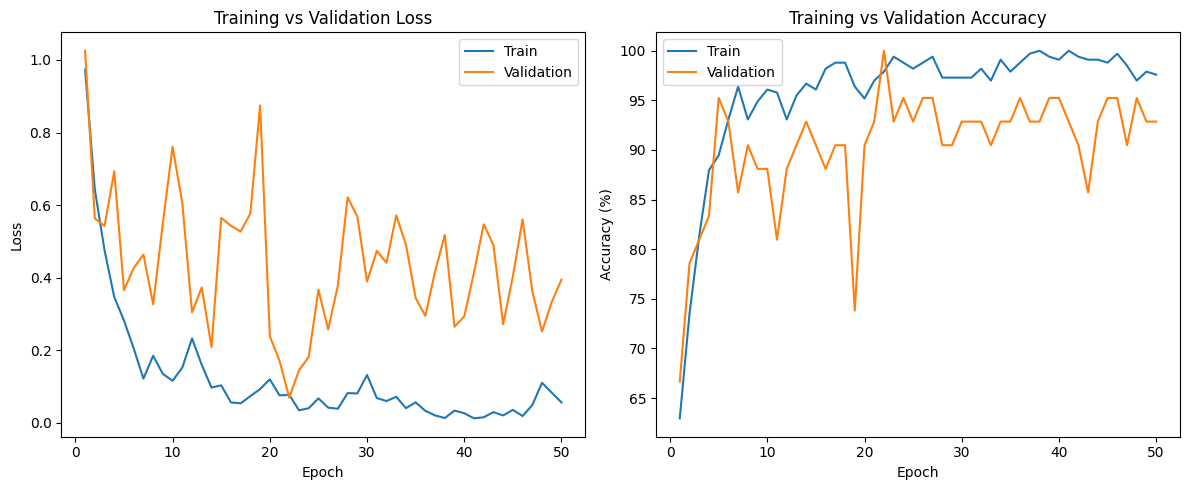

In [10]:
# ==========================
# 6️⃣ กราฟ Overfit
# ==========================
epochs = range(1, num_epochs + 1)

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss Plot
ax[0].plot(epochs, train_losses, label="Train")
ax[0].plot(epochs, valid_losses, label="Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training vs Validation Loss")
ax[0].legend()

# Accuracy Plot
ax[1].plot(epochs, train_accuracies, label="Train")
ax[1].plot(epochs, valid_accuracies, label="Validation")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Training vs Validation Accuracy")
ax[1].legend()

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()


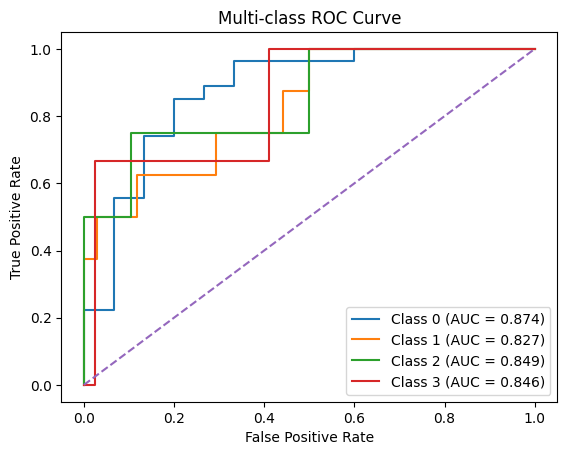

In [11]:
# ==========================
# 7️⃣ กราฟ AUC - ROC
# ==========================

# เก็บค่า y_true และ y_score จาก Test set
resnet50.eval()

y_true = []
y_score = []

with torch.no_grad():
    for images, labels in valid_loader:   # ควรใช้ valid_dataloader
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet50(images)
        probs = F.softmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

# กรณี Multi-class
# แปลง label เป็น one-hot
y_true_bin = label_binarize(y_true, classes=range(num_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# สร้างกราฟ ROC-AUC (Multi-class)
plt.figure()

for i in range(num_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"Class {i} (AUC = {roc_auc[i]:.3f})"
    )

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion Matrix:
[[20  4  2  1]
 [ 1  5  2  0]
 [ 0  1  2  1]
 [ 1  0  0  2]]

Accuracy: 0.6905
Precision: 0.7471
Recall: 0.6905
F1-Score: 0.7095


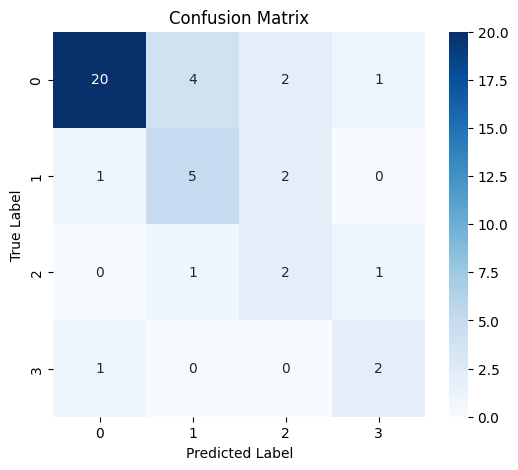

In [14]:
# confusion matrix (Validation Data)
resnet50.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in valid_loader:   # ควรใช้ valid_dataloader
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# สร้าง Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)

# Calculate and print additional metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# แสดงผลเป็น Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion Matrix:
[[214   3   0   0]
 [  0  61   0   0]
 [  0   0  33   0]
 [  0   1   0  20]]

Accuracy: 0.9880
Precision: 0.9887
Recall: 0.9880
F1-Score: 0.9881


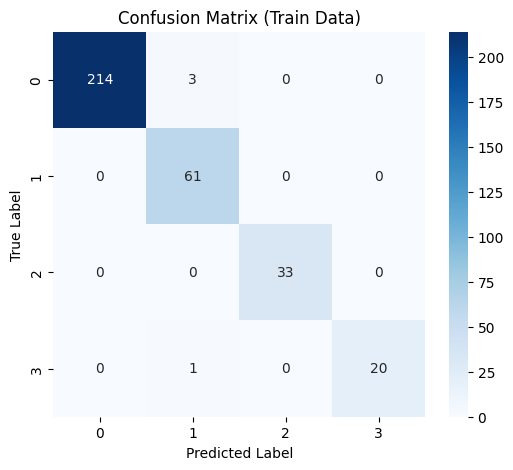

In [15]:
# confusion matrix (Train Data)
resnet50.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:   # Changed to train_loader
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# สร้าง Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)

# Calculate and print additional metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# แสดงผลเป็น Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Train Data)")
plt.show()
